In [1]:
import os.path

import torch
from torch import nn, optim

import numpy as np

% matplotlib inline
import matplotlib.pyplot as plt

from fashionmnist_cnn import *
from utils import *

In [2]:
DISABLE_CUDA = False

if not DISABLE_CUDA and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
dataset = FashionMNIST(
    os.path.join(*'data/fashionMNIST'.split('/')),
    batch_size=32, val_size=.2
)

In [4]:
model = load_model(fashionmnist_model(), os.path.join('models', 'fashionmnist.pt'), device)

model.eval()
test_accuracy = 0

with torch.no_grad():
    for X, y, label in dataset.test_loader:
        X = X.to(device); y = y.to(device)

        pred = model(X)
        test_accuracy += (torch.argmax(pred, 1) == y).sum()

test_accuracy = test_accuracy.item() / dataset.test_size

print('Test accuracy: %.3f' % test_accuracy)
print('Test error rate: %.3f' % (1 - test_accuracy))

Test accuracy: 0.920
Test error rate: 0.080


Epoch 001: train_loss = 379.195, val_loss = 299.368
Epoch 002: train_loss = 292.013, val_loss = 267.390
Epoch 003: train_loss = 275.424, val_loss = 258.057
Epoch 004: train_loss = 269.205, val_loss = 255.717
Epoch 005: train_loss = 266.191, val_loss = 251.335
Epoch 006: train_loss = 264.174, val_loss = 250.021
Epoch 007: train_loss = 263.029, val_loss = 249.103
Epoch 008: train_loss = 262.220, val_loss = 248.605
Epoch 009: train_loss = 261.528, val_loss = 248.779
Epoch 010: train_loss = 260.879, val_loss = 246.879
Epoch 011: train_loss = 260.056, val_loss = 246.271
Epoch 012: train_loss = 259.831, val_loss = 245.882
Epoch 013: train_loss = 259.431, val_loss = 245.849
Epoch 014: train_loss = 259.011, val_loss = 245.528
Epoch 015: train_loss = 258.601, val_loss = 246.343
Epoch 016: train_loss = 257.974, val_loss = 246.017
Epoch 017: train_loss = 257.920, val_loss = 246.302
Epoch 018: train_loss = 257.527, val_loss = 244.946
Epoch 019: train_loss = 257.297, val_loss = 245.279
Epoch 020: t

Epoch 159: train_loss = 250.465, val_loss = 240.382
Epoch 160: train_loss = 250.718, val_loss = 241.150
Epoch 161: train_loss = 250.655, val_loss = 240.451
Epoch 162: train_loss = 250.709, val_loss = 240.751
Epoch 163: train_loss = 250.672, val_loss = 240.369
Epoch 164: train_loss = 250.547, val_loss = 240.934
Epoch 165: train_loss = 250.475, val_loss = 240.513
Epoch 166: train_loss = 250.438, val_loss = 240.159
Epoch 167: train_loss = 250.464, val_loss = 240.397
Epoch 168: train_loss = 250.600, val_loss = 240.258
Epoch 169: train_loss = 250.523, val_loss = 240.095
Epoch 170: train_loss = 250.458, val_loss = 240.357
Epoch 171: train_loss = 250.506, val_loss = 240.356
Epoch 172: train_loss = 250.527, val_loss = 240.154
Epoch 173: train_loss = 250.481, val_loss = 240.263
Epoch 174: train_loss = 250.537, val_loss = 240.442
Epoch 175: train_loss = 250.467, val_loss = 240.379
Epoch 176: train_loss = 250.431, val_loss = 240.647
Epoch 177: train_loss = 250.409, val_loss = 240.419
Epoch 178: t

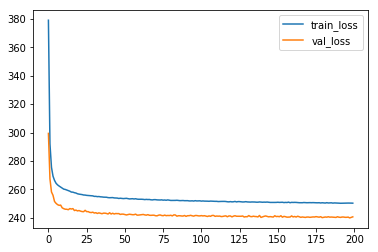

In [5]:
emb_dim = 100
N_EPOCHS = 200

vae = ConvVAE(emb_dim).to(device)
model_path = os.path.join('models', 'conv_vae_fashionmnist.pt')

optimizer = optim.Adam(vae.parameters())

train_losses = []
val_losses = []

# Train model
for epoch in range(1, N_EPOCHS + 1):
    vae.train()
    
    train_loss = 0
    
    for X, _, _ in dataset.train_loader:
        X = X.to(device)
        
        optimizer.zero_grad()
        recon_X, mu, logvar, code = vae(X)
        
        loss = vae.loss(recon_X, X, mu, logvar)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    train_loss /= dataset.train_size
    train_losses.append(train_loss)
    
    
    vae.eval()
    
    val_loss = 0
    
    with torch.no_grad():
        for X, _, _ in dataset.val_loader:
            X = X.to(device)

            optimizer.zero_grad()
            recon_X, mu, logvar, code = vae(X)
            loss = vae.loss(recon_X, X, mu, logvar)

            val_loss += loss.item()
        
    val_loss /= dataset.val_size
    val_losses.append(val_loss)
    
    print('Epoch %.3d: train_loss = %.3f, val_loss = %.3f' % (
        epoch, train_loss, val_loss
    ))
    

plt.plot(torch.Tensor(train_losses).cpu().detach().numpy(), label='train_loss')
plt.plot(torch.Tensor(val_losses).cpu().detach().numpy(), label='val_loss')
plt.legend();

torch.save(vae.state_dict(), model_path)

In [6]:
emb_dim = 100

vae = ConvVAE(emb_dim).to(device)
model_path = os.path.join('models', 'conv_vae_fashionmnist.pt')
vae.load_state_dict(torch.load(model_path))

vae = vae.eval()

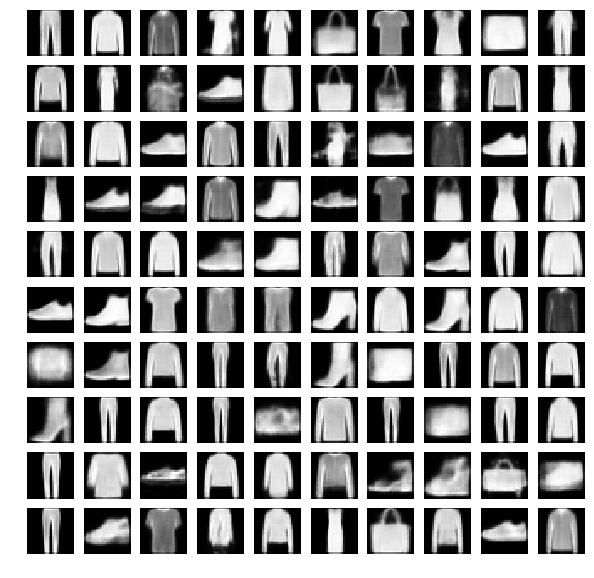

In [7]:
axes = subplots(10, 10, plot_size=1).flatten()

code = torch.randn(len(axes), emb_dim).to(device)
decoded = vae.decode(code)

for ax, img in zip(axes, decoded):
    imshow(img[0].detach(), ax)

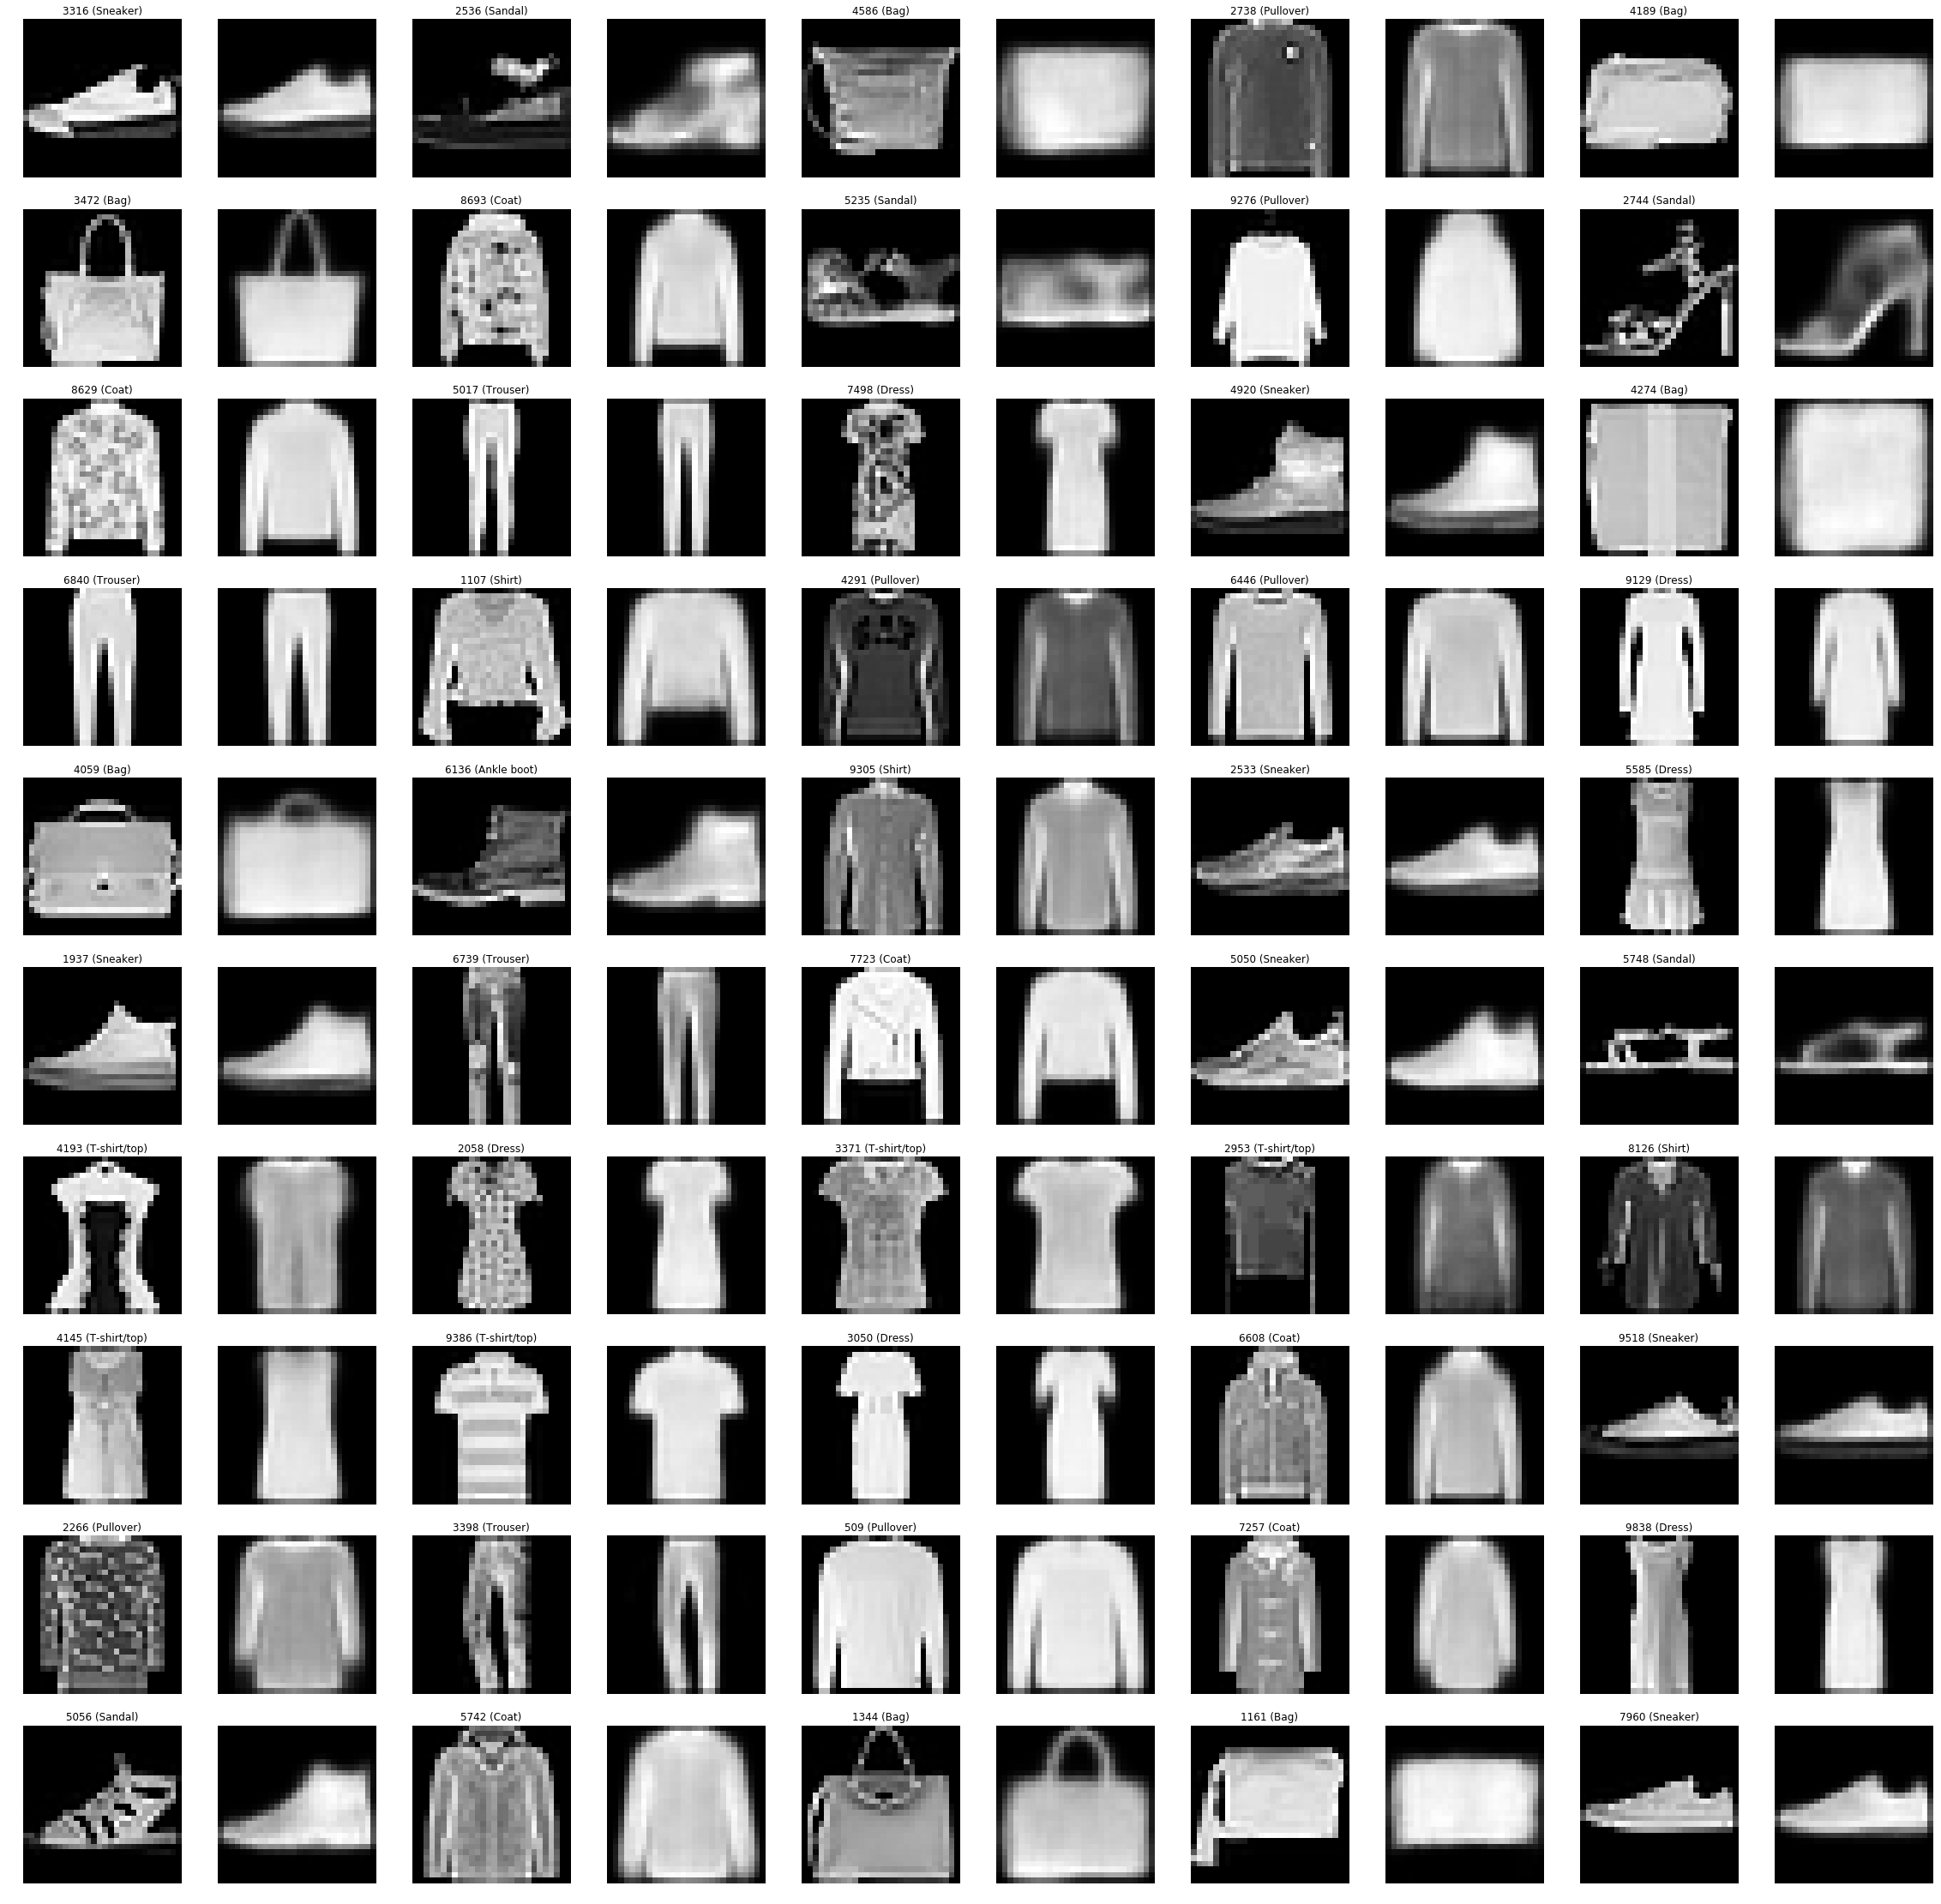

In [8]:
axes_mat = subplots(10, 10).reshape(50, 2)

idxs = np.random.choice(dataset.test_size, len(axes_mat), replace=False)

for axes, idx in zip(axes_mat, idxs):
    test_idx = dataset.test[idx]
    img, y, label = dataset[test_idx]
    img = img.to(device).unsqueeze(0)
    rec_img = vae(img)[0][0, 0].detach()
    
    imshow(img[0, 0].detach(), axes[0])
    axes[0].set_title('%d (%s)' % (idx, label))
    imshow(rec_img, axes[1])

We'll use the embedding norm as a measure of the likelihood of a code belonging to the manifold.

Let's analyze then the norm distribution:

In [9]:
codes = []
ys = []

for X, y, _ in dataset.train_loader:
    X = X.to(device)
    
    code, _ = vae.encode(X)
    codes.append(code.detach()); ys.append(y)
    
codes = torch.cat(codes)
ys = torch.cat(ys)
ys = ys.cpu().detach().numpy().astype(int)

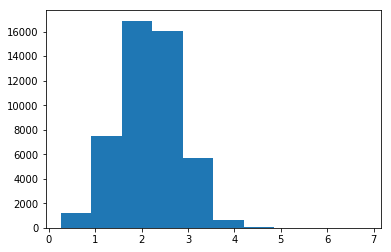

In [10]:
norms = codes.norm(p=2, dim=1).cpu().detach().numpy()
plt.hist(norms);

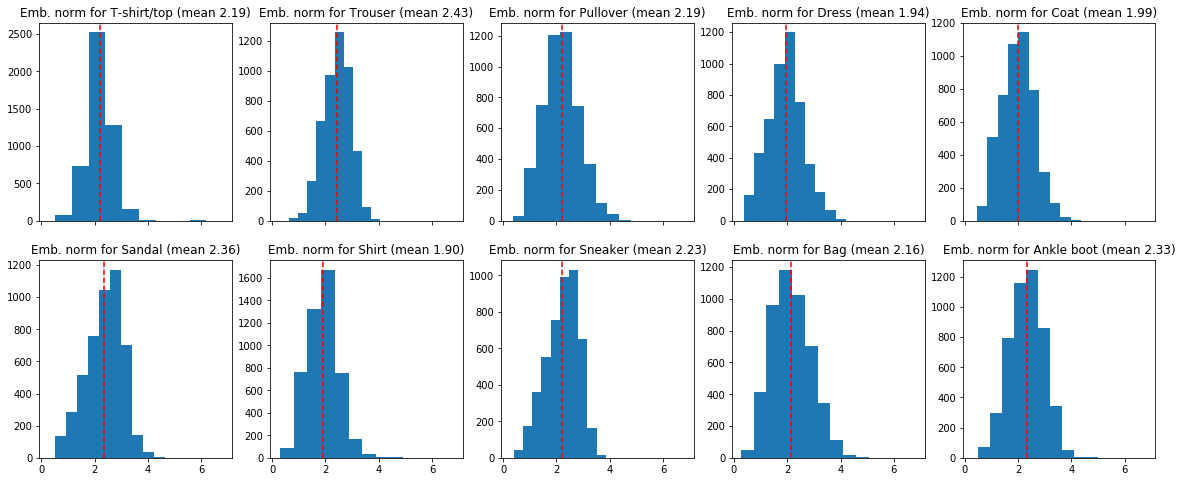

In [11]:
axes = subplots(2, 5, sharex=True).flatten()
class_means = {}

for y, ax in enumerate(axes):
    subset = norms[ys == y]
    norm_mean = subset.mean()
    class_means[int(y)] = float(norm_mean)
    
    ax.hist(subset)
    ax.axvline(norm_mean, linestyle='dashed', color='red')
    ax.set_title('Emb. norm for %s (mean %.2f)' % (dataset.classes[y], norm_mean))
    
class_means[-1] = float(norms.mean())

This is clearly not a normal distribution, even if we split by class. In any case, we'll still work by that assumption for the sake of simplicity.

In [12]:
class_means

{-1: 2.1720826625823975,
 0: 2.1901679039001465,
 1: 2.43392014503479,
 2: 2.1937754154205322,
 3: 1.9419515132904053,
 4: 1.9880778789520264,
 5: 2.361179828643799,
 6: 1.900506615638733,
 7: 2.227470636367798,
 8: 2.155830144882202,
 9: 2.327273368835449}

In [13]:
import json

with open('data/fashionmnist_conv_vae_norm_means.json', 'w') as f:
    json.dump(class_means, f)